In [104]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn
import scipy.cluster.hierarchy

In [105]:
#STEP 0 (parts 0-3)
#input_arr = np.genfromtxt("dros_gene_expression.csv", delimiter=',', names=True, dtype=None, encoding='utf-8')
#col_names = list(input_arr.dtype.names[1:])
#gene_names = input_arr["t_name"]
#fpkm_values = input_arr[col_names[1:]]
#fpkm_values_2d = rfn.structured_to_unstructured(fpkm_values, dtype=float)

#median = np.median(fpkm_values_2d, axis=1)
#filtered_array = np.log2(fpkm_values_2d[np.where(median>0)]+ 0.1)

In [106]:
#STEP 0
input_arr = np.genfromtxt("dros_gene_expression.csv", delimiter=',', names=True, dtype=None, encoding='utf-8')
gene_names = input_arr["t_name"] 
fpkm_values = input_arr[["male_10", "male_11", "male_12", "male_13", "male_14", "female_10", "female_11", "female_12", "female_13", "female_14"]] 
col_names = fpkm_values.dtype.names 
fpkm_values_2d = rfn.structured_to_unstructured(fpkm_values, dtype=float)

In [107]:
medians = np.median(fpkm_values_2d, axis=1) 
roi = medians > 0 
fpkm_values_2d_filt = fpkm_values_2d[roi,] 
fpkm_values_2d_filt_transform = np.log2(fpkm_values_2d_filt + 0.1) 

In [108]:
#STEP 1 (Part 1)
linkaged_matrix = scipy.cluster.hierarchy.linkage(filtered_array, method='single', metric='euclidean', optimal_ordering=False)
transposed_matrix = np.transpose(filtered_array, axes=None)
linkaged_transposed_matrix = scipy.cluster.hierarchy.linkage(transposed_matrix, method='single', metric='euclidean', optimal_ordering=False)

In [109]:
leaf_node_list_l = scipy.cluster.hierarchy.leaves_list(linkaged_matrix)
leaf_node_list_lt = scipy.cluster.hierarchy.leaves_list(linkaged_transposed_matrix)

In [110]:
sorted_data = filtered_array[leaf_node_list_l,:] 
further_sorted_data = sorted_data[:,leaf_node_list_lt]

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (9).

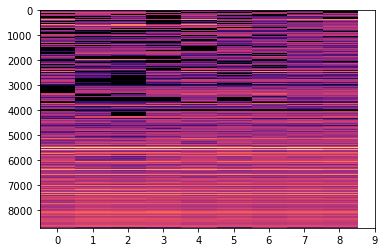

In [102]:
#STEP 1 (Part 2)
fig, ax = plt.subplots() # initialize your fix,ax
plt.imshow(further_sorted_data, aspect = 'auto', cmap='magma', interpolation = "nearest")
ax.set_xticks(np.arange(len(col_names)))
ax.set_xticklabels(np.array(col_names)[leaf_node_list_lt], rotation = 45)
plt.colorbar()

In [101]:
#STEP 1 (Part 3)
scipy.cluster.hierarchy.dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='C0')

NameError: name 'Z' is not defined